# Object Detection with MobileNet

This notebook demonstrates how to detect objects in images and videos using <b>MobileNet v3</b>, an efficient and lightweight computer vision model.

To get started, you must have the following requirements installed:

1. `opencv-python` - the official Python implementation of the OpenCV library
2. `matplotlib` - for displaying images and results graphically
3. `tensorflow` - to work with the MobileNet model
4. `notebook` - to run this notebook in a Jupyter server

It is recommended to have a virtual environment to isolate these requirements from the rest of your system. This can be done using Python's `virtualenv` package.

First, open a <b>Terminal</b> (<b>Command Prompt</b> on Windows) in the same folder as this notebook and create a virtual environment:

```shell
python3 -m venv env
```

Next, activate the virtual environment. For Windows users:

```shell
.\env\Scripts\activate
```

For Linux and MacOS users:

```shell
source env/bin/activate
```

Now you can safely install the above requirements in your virtual environment:

```shell
pip install opencv-python matplotlib tensorflow notebook
```

After installation is complete, launch the Jupyter server to edit this notebook:

```shell
jupyter notebook
```

## Getting Started

The following imports are necessary to work with this notebook:

In [1]:
# imports

import cv2
import matplotlib.pyplot as plt

## MobileNet

MobileNets are a family of deep learning models developed by Google Research for computer vision applications where computational resources are limited, such as mobile and embedded systems.

MobileNets are <b>CNNs</b> (Convolutional Neural Networks), which are a type of artificial neural network designed specifically for visual tasks (image classification, object identification etc.). However, unlike most CNNs, MobileNets are considerably more "lightweight". This is because MobileNets use <b>depth-wise separable convolutions</b>.

Depth-wise separable convolutions are a type of convolution operation used in CNN models designed for mobile and embedded devices. Depth-wise separable convolutions work in two steps:

1. Depth-wise convolution
2. Point-wise convolution

Here's how it works:

In regular convolutions, a single filter (commonly known as a "kernel") is applied to the entire input volume (the 3D input data that is fed into the model). The filter slides through the input volume, computing <b>dot products</b> at each position. This helps the model identify edges, textures and patterns.

<img src="./img/regular-convolution.png">
<i>Fig 1: Regular convolution</i>

<br><br>

In depth-wise convolution, the filter and the input volume are separated into <b>channels</b> which are usually the three color channels of the image (<b>RGB</b>). Then, each "layer" of the input volume is convolved with its own filter. The output of each channel then gets stacked together.

<img src="./img/depth-wise-convolution.png">
<i>Fig 2: Depth-wise convolution</i>

<br><br>

Next, point-wise convolutions take over. Here, the output of the depth-wise convolution process gets combined using a `1x1` filter, resulting in a single-channel output.

A diagrammatic representation of this full process is given below:

<img src="./img/depth-wise-separable-convolution.png">
<i>Fig 3: Depth-wise separable convolution</i>

<br><br>

Depth-wise separable convolutions allow MobileNet models to work with a limited number of parameters and lower memory requirements, which reduces the chances of overfitting while maintaining a reasonable level of accuracy.

## The Model

To work with a MobileNet model, we need to load data from two files:

1. The model itself: this file holds the pre-trained MobileNet model in a serialized format (usually ending in `.pb`). This file contains the actual weights and the architecture of the model.
2. The configuration file: this is the model definition, containing "metadata" about the model, such as the model's input-output nodes, the preprocessing steps applied to the data, and more.

In [91]:
# load the pre-trained model and its configurations into memory

frozen_model="frozen_inference_graph.pb"
config_file="ssd_mobilenet_v3_large_coco_2020_01_14.pbtxt"

The file name of the model definition contains information about the model that we are using.

1. SSD - stands for <b>Single Shot Detector</b>. SSD models can perform object detection over a single pass through the neural network, providing remarkable levels of performance and efficiency.
2. MobileNet - the family of CNN models being used.
3. V3 - the third iteration of MobileNet, which includes performance improvements over previous versions.
4. Large - the size variant of the MobileNet model (from `small`, `medium` and `large`), with `large` models providing higher accuracy at the cost of increased computational requirements.
5. COCO - a popular dataset used to train models for image recognition, object detection and captioning tasks.
6. January 14, 2020 - the date of training (or <b>date of release</b>) of the model.

To perform object detection using the capabilities of the pre-trained MobileNet model, we can create an instance of `dnn_DetectionModel` from the OpenCV library.

In [54]:
# create instance of dnn_DetectionModel for object detection using MobileNet

model = cv2.dnn_DetectionModel(
    model=frozen_model,
    config=config_file
)

MobileNet SSD V3 has been trained to identify objects belonging to over 80 unique classes. We can use a set of <b>labels</b> (provided from a text file) to enumerate over the integer output provided by the model after inference, to accurately label objects detected in images.

In simpler terms, the MobileNet model outputs an integer value corresponding to any object detected in an image (e.g. `0` for "human", `1` for "dog", `2` for "cat" etc.). To label these integer outputs with the relevant English words, we can load these words from a text file.

In [63]:
# initialize empty list to store object labels
class_labels = []

# load labels for objects from text file
file_name = "labels.txt"
with open (file_name,"rt") as fpt:
    class_labels = fpt.read().rstrip("\n").split("\n")

print(class_labels)

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


Next, we must setup the preprocessing to be done on the input data (either images or videos) before providing it to the model. This includes:

1. Changing the input data to `320x320` pixels in size.
2. Scaling the data to a pre-defined scale (`1/127.5` in this scenario).
3. Setting the input mean of the model, i.e. reducing a mean value (usually 127.5) from each value for `R`, `G` and `B` in each pixel in the data. This helps center the input data around zero, improving the performance of the model.
4. Swapping the Red and Blue color channels of the data. This is because OpenCV usually loads data in the BGR format, but MobileNet models can only work with data in the RGB format.

In [62]:
# setup preprocessing steps for input data

model.setInputSize(320,320)
model.setInputScale(1.0/127.5)
model.setInputMean((127.5,127.5,127.5))
model.setInputSwapRB(True)

< cv2.dnn.Model 0x7f86aefca690>

Now, let's load a sample image of a man and a car overlapping each other to see how well MobileNet performs.

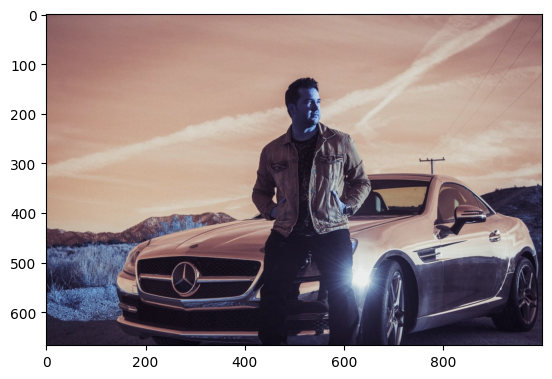

In [86]:
# load sample image
img = cv2.imread("./img/man-and-car.jpg")

# display image
plt.imshow(img)

Notice how the `R` and `B` color channels have been swapped in the above image, since this image has been loaded using OpenCV. We must revert these changes before providing this image to the model.

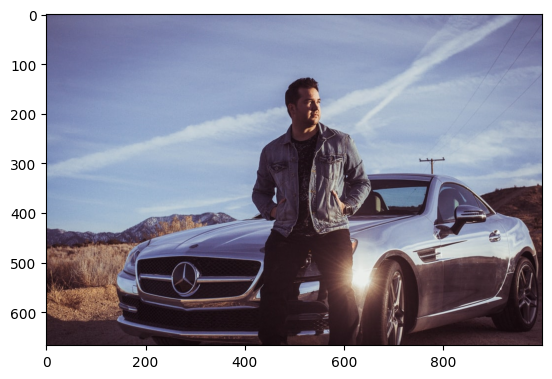

In [87]:
# swap red and blue color channels of image
converted_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display processed image
plt.imshow(converted_img)

Finally, we can call `model.detect()` on the processed image to retrieve a list of objects detected in the image. This function takes in two arguments:

1. The input image, converted from BGR format to RGB format.
2. The confidence threshold, which is the level at which detections will be considered. For example, for a confidence threshold of `0.5`, only detections having a confidence of <b>50% or more</b> will be considered.

It returns three values:

1. The index of the label of the object. This is an `int` value.
2. The confidence score (i.e. probability) of the predictions made by the model.
3. The coordinates of the bounding boxes to be mapped on the detected objects.

In [88]:
# detect objects in the image using the MobileNet model
class_index, confidence, bounding_box_coordinates = model.detect(img, confThreshold=0.5)

# show model outputs
print(class_index)

[1 3]


We can now draw bounding boxes around the image to visualize the outputs of the model. For this, we must iterate over three lists (arrays) simultaneously:

1. `class_index`
2. `confidence`
3. `bounding_boxes`

These lists must be flattened (converted into 1D arrays for easier processing), after which the `zip()` function pairs together elements from each list for every iteration of the loop.

In [89]:
for class_index, confidence, bounding_boxes in zip(class_index.flatten(), confidence.flatten(), bounding_box_coordinates):
    
    # draw bounding boxes on detected objects
    cv2.rectangle(
        img,                # the image on which the bounding boxes must be drawn
        bounding_boxes,     # the positions and sizes of the bounding boxes
        (255,0,0),          # the color of the bounding boxes (in this case, blue)
        2                   # the thickness of the lines in the bounding boxes
    )
    
    # label the bounding boxes with the relevant class labels
    cv2.putText(
        img,                                              # the image on which the bounding boxes are drawn
        class_labels[class_index-1],                      # the relevant class labels (obtained from the `class_index` list)
        (bounding_boxes[0]+10, bounding_boxes[1]+40),     # the location of the labels (near the top-left corner of the bounding boxes)
        fontFace=cv2.FONT_HERSHEY_PLAIN,                  # the font of the labels on the bounding boxes
        fontScale=2,                                      # the font size of the labels
        color=(0,255,0),                                  # the font color of the labels
        thickness=3                                       # the thickness of the text of the labels
    )  

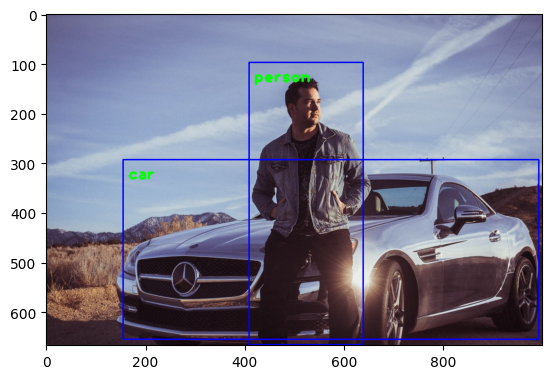

In [90]:
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

Here, we can easily notice how accurately the MobileNet model has performed on the input image.